To run predictions, you first need to place the trained model file (.pt format) into the current directory

In [ ]:
import sys 
sys.path.append("AttentiveFP/code")

import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from AttentiveFP import Fingerprint, save_smiles_dicts, get_smiles_array

In [ ]:
from rdkit import Chem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

/home/slavick/miniconda3/envs/AttentiveFP_env/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [3]:
seed = 42

In [4]:
start_time = str(seed)

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
output_units_num = 1 # for regression model
radius = 2
T = 4

number of all smiles:  42006
number of successfully processed smiles:  42006


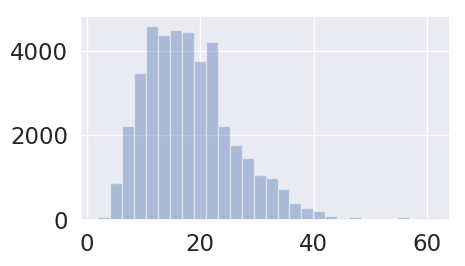

In [ ]:
task_name = 'GLP_dataset'
tasks = ['logp']

raw_filename = "data/separate_data/GLP_dataset.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.molecule.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["molecule"].isin(remained_smiles)]
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()

In [6]:
smiles_tasks_df.head()

,molecule,logp,dataset_type,cano_smiles
0,BrBr,1.03,train,BrBr
1,BrC(Br)(Br)c1ccc2ccccc2n1,4.31,validation,BrC(Br)(Br)c1ccc2ccccc2n1
2,BrC(Br)=C(Br)Br,2.57,train,BrC(Br)=C(Br)Br
3,BrC(Br)C(Br)(Br)Br,3.56,train,BrC(Br)C(Br)(Br)Br
4,BrC(Br)C(Br)Br,2.55,test,BrC(Br)C(Br)Br


In [ ]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
print("not processed items")
uncovered_df

feature dicts file saved as GLP_dataset.pickle
not processed items


,molecule,logp,dataset_type,cano_smiles


In [8]:
remained_df.head()

,molecule,logp,dataset_type,cano_smiles
0,BrBr,1.03,train,BrBr
1,BrC(Br)(Br)c1ccc2ccccc2n1,4.31,validation,BrC(Br)(Br)c1ccc2ccccc2n1
2,BrC(Br)=C(Br)Br,2.57,train,BrC(Br)=C(Br)Br
3,BrC(Br)C(Br)(Br)Br,3.56,train,BrC(Br)C(Br)(Br)Br
4,BrC(Br)C(Br)Br,2.55,test,BrC(Br)C(Br)Br


In [ ]:
remained_df = remained_df.reset_index(drop=True)
test_df = remained_df[remained_df['dataset_type'] == 'test']
training_data = remained_df[remained_df['dataset_type'] == 'train']

valid_df = remained_df[remained_df['dataset_type'] == 'validation']
train_df = training_data # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)




In [ ]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()


optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [11]:
def eval(model, dataset):
    model.eval()
    preds = []
    true_vals = []
    smiles_all = []

    valList = np.arange(0, dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 

    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch, :]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values

        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(
            smiles_list, feature_dicts
        )

        _, mol_prediction = model(
            torch.Tensor(x_atom),
            torch.Tensor(x_bonds),
            torch.cuda.LongTensor(x_atom_index),
            torch.cuda.LongTensor(x_bond_index),
            torch.Tensor(x_mask)
        )

        preds.extend(mol_prediction.data.squeeze().cpu().numpy())
        true_vals.extend(y_val)
        smiles_all.extend(smiles_list)

    df = pd.DataFrame({
        "smiles": smiles_all,
        "logp": true_vals,
        f"logP_pred_{seed}": preds
    })
    return df

In [12]:
# evaluate model
best_model = torch.load(f'GLP_dataset_{str(seed)}.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
df = eval(model, test_df)

In [13]:
df.head()

,smiles,logp,logP_pred_42
0,BrC(Br)C(Br)Br,2.55,2.561312
1,BrCCCCCCCBr,4.47,4.556057
2,BrCCN(CCBr)c1ccccc1,3.84,3.701992
3,Brc1cc(Br)c(Br)c(Br)c1,5.55,5.129411
4,Brc1cc(Br)c(Br)s1,4.48,4.302762


In [14]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
r2 = r2_score(df['logp'], df[f'logP_pred_{seed}'])
rmse = np.sqrt(mean_squared_error(df['logp'], df[f'logP_pred_{seed}']))
mae = mean_absolute_error(df['logp'], df[f'logP_pred_{seed}'])
round(rmse, 3), round(r2, 3), round(mae, 3)

(0.507, 0.943, 0.319)

In [15]:
df.to_csv('Seeds_Predict_AttentiveFP_GLP_train_GLP_test.csv', index=False)